# Business data analysis - Finding popular Data Science topics

`categories: data analysis in business, working with APIs, exploratory data analysis`

In this project, we're going to assume we work for a company which creates contents about Data Science (DS). These contents may take the form of articles, blog posts, videos, all related to the field of Data Science.<br/>
Let's assume **our manager has asked us to determine the best topics to write about or for producing videos**. The problem, as it's stated, is ill-defined but we've been given the freedom to define what 'best' means in this context and to tackle the problem as we please.

This is an example of **fuzzy language** in business: transforming an undefined into a defined question is part of the job of a data analyst in a business context.

## What are we searching for?

Because we were left free to define the problem as we please, at first we decided to focus our attention on the [Data Science community](https://datascience.stackexchange.com/) of **Stack Exchange**.

Stack Exchange (SE) is a very popular network of sites where anybody can post a question and receive answers from other users. Each of the 173 sites is about a different subject/topic. Stack Overflow is the largest of this sites, used daily by programmers to find solutions to their problems.<br/>
SE is based on an upvote/downvote mechanism; users can vote questions, answers and comments, and the answers with the highest net score are always shown on top. The user who has posted the question can decide to accept one of the answers as the most satisfying.

The **Data Science community of Stack Exchange** (DSSE from now on) is also quite active and it has a dedicated [data explorer](https://data.stackexchange.com/datascience/queries) from which one can gather all kinds of information and statistics.<br/>
The data of the DSSE data explorer can be very useful to understand **which topics may be promising for online articles/blog posts**.<br/> 
The data explorer is implemented as a Transact-SQL database. It contains lots of tables, but we decided to use only the **Posts** table.<br/> 
The query is the following:

        SELECT Id, 
               Score, 
               ViewCount, 
               AnswerCount, 
               FavoriteCount, 
               Tags, 
               CreationDate
        FROM Posts
        WHERE PostTypeId = 1 AND CreationDate >= '2020-10-01';
        
PostTypeId = 1 identifies questions and we decided to consider the data related to the last year.<br/>
The fields `Score`, `ViewCount`, `AnswerCount`, `FavoriteCount` are self-explanatory and potentially each of them is a candidate metric for measuring the popularity of topics in DS. 

As we'll see, similar kinds of data will be gathered in order to determine the best topics for producing videos.

Let us familiarize with the data from DSSE.

### Modules and plot settings

For the sake of convenience, we will import all the needed modules in the next cell; also, the plot settings will be included.

In [1]:
# for the sake of convenience, we will import 
# all the needed Python libraries in this cell

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pprint import pprint
import requests
import seaborn as sns

# general settings for the plots
sns.set_style('darkgrid') # seaborn style (darkgrid, white grid, dark, white and ticks)
plt.style.use('seaborn-darkgrid')  # pyplot style
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

# use the next line for displaying the available styles
# plt.style.available

This is used to avoid plot box with scrolling: 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## A look at the data from DSSE

In [3]:
# loading the data from a local csv file
df = pd.read_csv('./datasets/SEDE_DSSE_questions_data.csv',
                 parse_dates=['CreationDate'])

# performing some quick cleaning-processing operation 
# (data are already very well-maintained)
df.fillna({'FavoriteCount': 0}, inplace=True)
df['FavoriteCount'] = df['FavoriteCount'].astype(int)
df['Tags'] = df['Tags'].str.replace('><', ', ').str.replace('[<>]', '').str.split(', ')

As we see in the next cell, the dataframe `df` has data about **6766 posts**, no more null values and the data types are appropriate.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6766 entries, 0 to 6765
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6766 non-null   int64         
 1   Score          6766 non-null   int64         
 2   ViewCount      6766 non-null   int64         
 3   AnswerCount    6766 non-null   int64         
 4   FavoriteCount  6766 non-null   int64         
 5   Tags           6766 non-null   object        
 6   CreationDate   6766 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 370.1+ KB


From the summary statistics in the next cell, we see there are no outliers or manifestly wrong values in the numeric columns of the dataframe.

In [5]:
df.describe().iloc[:, 1:]

,Score,ViewCount,AnswerCount,FavoriteCount
count,6766.000000,6766.000000,6766.000000,6766.000000
mean,0.621046,85.534289,0.610109,0.086018
std,1.047318,435.654695,0.710752,0.334279
min,-2.000000,2.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,0.000000
50%,0.000000,27.000000,1.000000,0.000000
75%,1.000000,50.000000,1.000000,0.000000
max,29.000000,15178.000000,8.000000,6.000000


Let's look at a random sample of the data contained in `df`.

In [6]:
df.sample(10)

,Id,Score,ViewCount,AnswerCount,FavoriteCount,Tags,CreationDate
2432,93921,0,31,0,0,"[machine-learning, predictive-modeling, prepro...",2021-05-03 16:57:36
5638,99818,0,20,1,0,"[machine-learning, neural-network, dataset, ma...",2021-08-07 12:53:08
5841,87180,0,31,0,0,"[pytorch, transformer]",2020-12-26 20:14:17
6053,100273,0,35,1,0,"[keras, gpu, aws, sagemaker]",2021-08-19 10:57:26
4212,97102,2,46,1,0,"[reinforcement-learning, q-learning]",2021-06-25 15:30:05
1992,93013,0,68,0,0,"[machine-learning, python, neural-network, ten...",2021-04-13 14:09:11
234,88744,1,22,0,0,[dimensionality-reduction],2021-01-31 09:09:58
6488,101974,0,15,0,0,"[keras, tensorflow, sentiment-analysis, huggin...",2021-09-11 13:20:53
2287,93640,0,24,1,0,[one-hot-encoding],2021-04-27 20:18:07
6707,102372,1,15,0,0,"[data-cleaning, numpy]",2021-09-23 05:56:41


The cleaning operation on the `Tags` column transformed a string with a list of tags characterising the post into an actual Python list:

In [7]:
print(type(df['Tags'][0]))

<class 'list'>


## Most used and viewed tags in DSSE

As we said, we could use each of the columns from `Score` to `FavoriteCount` as a metric for ranking the tags/topics.<br/> 
We could even combine them in a weighted sum.

If we assume that this is a "quick project" and we have little time to give our manager some clues, the best approach is probably to stay simple: we decided to **rank each tag** according to **how many times it was used and its cumulative views**.

In order to determine both, though, we need to consider each tag separately, while they are aggregated in a list for each question. We can reach this goal by using the `explode()` function in pandas.

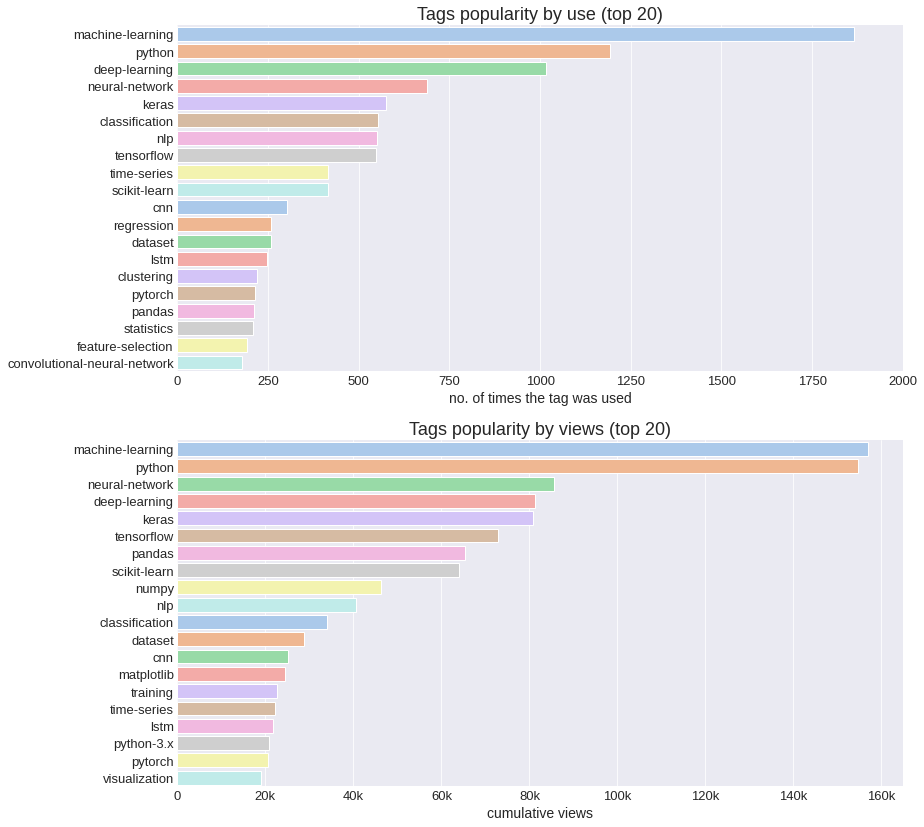

In [8]:
# processing the data (top 20 tags)
most_used_tags = df.explode('Tags')['Tags'].value_counts()[:20]
most_viewed_tags = df.explode('Tags').groupby('Tags').agg('sum')['ViewCount'].sort_values(ascending=False)[:20]

########################
# PLOTTING THE FIGURES #
########################
fig, (ax_up, ax_bottom) = plt.subplots(2, 1, figsize=(13,14))

# UPPER FIGURE: TAGS USAGE
ax_up = sns.barplot(y=most_used_tags.index,
                    x=most_used_tags.values,
                    orient='h',
                    palette='pastel', 
                    ci=None,
                    ax=ax_up)

ax_up.set_xlim([0, 2000])
ax_up.set(title='Tags popularity by use (top 20)', xlabel='no. of times the tag was used', ylabel='')
ax_up.grid(b=False, axis='y')

# LOWER FIGURE: TAGS VIEWS
ax_bottom = sns.barplot(x=most_viewed_tags.values,
                        y=most_viewed_tags.index,
                        orient='h',
                        palette='pastel',
                        ci=None,
                        ax=ax_bottom)

ax_bottom.set(title='Tags popularity by views (top 20)', xlabel='cumulative views', ylabel='')

def format_xtick_labels(view_count, x):
    '''ex: 20000 -> 20k
       x is the thick position'''
    if view_count != 0:
        return '{}k'.format(int(view_count / 1e3))
    return '0'

formatter = FuncFormatter(format_xtick_labels)
ax_bottom.xaxis.set_major_formatter(formatter)

### Some observations:
- **Machine learning** and **Python** are the most used and viewed tags. They both were used in more than 1000 questions and had more than 150,000 cumulative views.
 
- Following, there are **deep learning** (DL, a subfield of machine learning), **neural networks** (a particular class of DL algorithms inspired by the neural connections in the brain), **Keras** (a DL library in Python which provides a high-level interface to the ML library  **TensorFlow**, also very popular by both metrics) and **natural language processing** (NLP, a class of problems related to the interpretation/generation of human language; it has become a very popular and in demand skill in DL, nowadays).

- **Convolutional neural networks**' tag (splitted in two in the upper plot) was used more than 500 times in DSSE questions. CNN are among the most popular and used neural networks.
- **Pandas**, the Python library we're using in this project, is very popular views-wise, just under the ML/DL topics and subtopics. It's closely followed by **Numpy**, the module on which Pandas is built.
- **Matplotlib** and **visualization** are not present in the top 20 tags by usage, but they have reached more than 40,000 views in the last year, as a whole. This means that posts about these topics generally have large views.
- We can finally observe that **R**, another very famous programming language for data science, doesn't appear in either list.

## Is deep learning just a fad?

From the previous results, using some domain knowloedge, we have understood that deep learning and deep-learning related topics are the most popular topics, taken together.

But is it just a fleeting fad? Have their popularity steadily grown over time? Or is it even decreasing? We dont't want to advise our manager to invest in a field which is "fading away".

Let's look at the time series of the **monthly percentage of posts related to deep learning** (with respect to the total number of questions posted).<br/>
We go back to the DSSE explorer and run this query:

    SELECT Id, CreationDate, Tags 
    FROM Posts 
    WHERE PostTypeId = 1;

In [9]:
# load the data from a local csv file
df_dl = pd.read_csv('./datasets/all_questions.csv', 
                    parse_dates=['CreationDate'])

# extract tags list for each post
df_dl['Tags'] = df_dl['Tags'].str.replace('><', ', ').str.replace('[<>]', '').str.split(', ')

Our `df_dl` dataframe contains no null-values and has data about more than 30,000 posts. 

In [10]:
df_dl

,Id,CreationDate,Tags
0,27498,2018-02-05 19:56:47,"[machine-learning, neural-network, deep-learni..."
1,27501,2018-02-05 22:00:50,"[clustering, k-means, unsupervised-learning]"
2,27502,2018-02-06 04:36:44,"[machine-learning, cross-validation, training,..."
3,27505,2018-02-06 05:30:55,[r]
4,27506,2018-02-06 05:38:31,"[machine-learning, cnn, convolutional-neural-n..."
...,...,...,...
30584,102481,2021-09-25 16:52:19,"[scikit-learn, preprocessing, one-hot-encoding]"
30585,102483,2021-09-25 21:34:23,"[machine-learning, python, deep-learning, neur..."
30586,102484,2021-09-25 22:11:32,"[deep-learning, keras, scikit-learn]"
30587,102486,2021-09-26 00:45:55,"[machine-learning, classification, evaluation,..."


In the next cell, we classify posts as DL-related or not according to the tags they are associated to (look at [this article](https://www.mygreatlearning.com/blog/types-of-neural-networks/#:~:text=The%20three%20most%20important%20types,Recurrent%20Neural%20Networks%20(RNN)) if you want to know more about neural networks).

In [11]:
# DL-related tags
dl_tags = ['deep-learning', 'neural-network', 'keras', 'convolutional-neural-network', 'cnn', \
           'recurrent-neural-network', 'rnn']

def check_if_deep_learning_related(tags_list):
    '''return True if the tags list contains one item of dl_tags'''
    if len(set(dl_tags).intersection(set(tags_list))) != 0:
        return True
    return False

# apply the function to the 'Tags' column
df_dl['is_about_deep_learning'] = df_dl['Tags'].apply(check_if_deep_learning_related)
# extract year-month from the post creation date, bc we're
# interested in monthly pct of posts
df_dl['time_period'] = df_dl['CreationDate'].dt.to_period('M')

In [12]:
df_dl.sample(5)

,Id,CreationDate,Tags,is_about_deep_learning,time_period
15430,93718,2021-04-29 09:33:42,"[neural-network, gradient-descent]",True,2021-04
20670,34204,2018-07-09 15:53:37,"[neural-network, anomaly-detection, autoencoder]",True,2018-07
1423,40798,2018-11-06 06:46:29,"[machine-learning, python, deep-learning, kera...",True,2018-11
21539,35659,2018-07-18 10:25:58,"[neural-network, data-mining, feature-engineer...",True,2018-07
17028,33002,2018-06-12 08:59:11,"[r, clustering, k-means]",False,2018-06


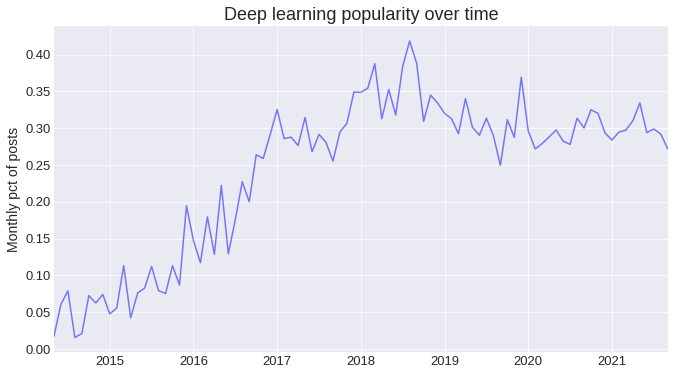

In [13]:
# calculating monthly pct of deep learning related posts
monthly_pct = df_dl.groupby('time_period').mean()['is_about_deep_learning']

# plotting results
fig, ax = plt.subplots(figsize=(11,6))
ax = monthly_pct.plot(kind='line', color='blue', alpha=0.5, 
                      legend=False, 
                      ax=ax)

ax.set(title='Deep learning popularity over time', xlabel='', ylabel='Monthly pct of posts')
plt.show()

We see that the share of deep learning questions in DSSE **increased steadily** in the years 2014-2018 with a peak over 40%.<br/>
From 2019, instead, the percentage of posts oscillated **around 30%**, remaining quite constant.

These results are an indication that interest in deep learning topics won't probably fade away anytime soon.

## What about video contents? DataCamp Youtube channel statistics

After the analysis of DSSE for finding the most promising topics for online articles, we turned our attention to video contents.

We focused on the DataCamp Youtube channel, which contains lots of videos mostly dedicated to data science. We chose one particular channel because an analysis of the whole of YT is clearly out of scope for such a quick project.

The kind of analysis we will perform is analogous to the previous, what is very different is the gathering of data. We didn't have a database at our disposal, so we had to resort to the **Youtube Data API v3**.<br/>
It's part of the ecosystem of Google APIs, and you need to set up an account and obtain an API key in order to use it.<br/>
You can find all the information in the official docs ([starting here](https://developers.google.com/youtube/v3/getting-started) with information about each method [here](https://developers.google.com/youtube/v3/docs)).

We will define a class with the data and methods we need to query the API:

In [14]:
class YoutubeAPI():
    
    def __init__(self, api_key, channel_id, playlist_id):
        self.api_key = api_key
        self.channel_id = channel_id
        self.playlist_id = playlist_id
        self.base_url = "https://youtube.googleapis.com/youtube/v3/"
        
    def get_channel_general_info(self):
        '''Return a dictionary with main info about the channel
           (subscribers, total views etc.)'''
        endpoint = f"channels?part=snippet%2C%20statistics&id={self.channel_id}&key={self.api_key}"
        resp = requests.get(self.base_url + endpoint)
        if resp.status_code != 200:
            print('Something went wrong while getting channel info...')
            return
        
        return resp.json()['items'][0]['statistics']
    
  
    def get_all_videos_ids(self):
        '''Return a list with the ids of all the videos in the channel.
           It uses pagination to retrieve all the data.'''
        first_page_endpoint = f"playlistItems?part=snippet&maxResults=50&playlistId={self.playlist_id}&key={self.api_key}"
        
        # initializing the list with first page of results
        resp = requests.get(self.base_url + first_page_endpoint)
        if resp.status_code != 200:
            print('Something went wrong while hitting playlistItems.')
            return
        video_ids = [video['snippet']['resourceId']['videoId'] for video in resp.json()['items']]

        # pagination    
        while True:
            next_page_token = resp.json().get('nextPageToken', None)
            if next_page_token is None:
                break
            else:
                next_page_endpoint = f"playlistItems?part=snippet&pageToken=" +\
                                     f"{next_page_token}&maxResults=50&playlistId=" +\
                                     f"{self.playlist_id}&key={self.api_key}"
                resp = requests.get(self.base_url + next_page_endpoint)
                if resp.status_code != 200:
                    print('Something went wrong during pagination.')
                    break
                resp.json()['items']
                video_ids.extend([video['snippet']['resourceId']['videoId'] for video in resp.json()['items']])
                
        return video_ids   
    
    def get_info_about_videos(self, video_ids_list):
        '''Return info (title, duration, views, likes etc.) 
           about all the videos whose ids are in the given list.
           It returns a list of dictionaries.'''
        
        video_info = []
        print('Getting info about all videos...')
        
        for i, video_id in enumerate(video_ids_list):
            endpoint = f"videos?part=snippet%2C%20statistics%2C%20" +\
                       f"contentDetails&id={video_id}&key={self.api_key}"
            resp = requests.get(self.base_url + endpoint)
            if resp.status_code != 200:
                print(f'Bad req. for video no {i}')
                continue
            else:
                resp_json = resp.json()
                video_info.append({'title': resp_json['items'][0]['snippet']['localized']['title'],
                           'id': resp_json['items'][0]['id'],
                           'duration': resp_json['items'][0]['contentDetails']['duration'],
                           'tags': resp_json['items'][0]['snippet'].get('tags', None),
                           'views': resp_json['items'][0]['statistics']['viewCount'],
                           'likes': resp_json['items'][0]['statistics']['likeCount'],
                           'dislikes': resp_json['items'][0]['statistics']['dislikeCount'],
                           'creation_date': resp_json['items'][0]['snippet']['publishedAt']})
            
        return video_info    


These are the data we need to use the class we have just defined:

In [15]:
with open('./datasets/yt_API_key') as f:
    API_KEY = f.read()
# the channel ID can be found in the html explorer for the
# channel page under the keyword "externalId"
channel_id = "UC79Gv3mYp6zKiSwYemEik9A" 
# notice that for this channel the playlist ID is just
# the channel ID with C->U. This isn't always true.
playlist_id = "UU79Gv3mYp6zKiSwYemEik9A"

We are now ready to instantiate our class and call its methods (it takes a few mins to download all the info):

In [16]:
yt_api = YoutubeAPI(API_KEY, channel_id, playlist_id)

print('Datacamp YT channel summary statistics:')
pprint(yt_api.get_channel_general_info())
video_ids = yt_api.get_all_videos_ids()
print(f'\nGot {len(video_ids)} video ids.\n')
video_info = yt_api.get_info_about_videos(video_ids)
print(f'\nGot info about {len(video_info)} videos.')

Datacamp YT channel summary statistics:
{'hiddenSubscriberCount': False,
 'subscriberCount': '121000',
 'videoCount': '1219',
 'viewCount': '17174894'}

Got 1219 video ids.

Getting info about all videos...

Got info about 1219 videos.


Let's see what we obtained form the API:

In [17]:
df_yt = pd.DataFrame(video_info)
df_yt.info()
df_yt.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          1219 non-null   object
 1   id             1219 non-null   object
 2   duration       1219 non-null   object
 3   tags           1171 non-null   object
 4   views          1219 non-null   object
 5   likes          1219 non-null   object
 6   dislikes       1219 non-null   object
 7   creation_date  1219 non-null   object
dtypes: object(8)
memory usage: 76.3+ KB


,title,id,duration,tags,views,likes,dislikes,creation_date
0,Live Code Along - How to quickstart your data ...,ZxkddEPbig0,PT1H27M4S,"[data science, data scientist, data, analytics...",872,29,0,2021-10-04T18:59:53Z
1,#72 Building High Performing Data Teams (with ...,_GXSpij2-UE,PT50M37S,"[podcast, data science, data scientist, data, ...",164,8,0,2021-10-04T12:56:05Z
2,#71 Scaling Machine Learning Adoption: A Pragm...,AUvAdkDvvto,PT49M30S,"[podcast, data science, data scientist, data, ...",536,10,0,2021-09-20T12:01:12Z


All the fields are strings, so we'll now perform some casting/cleaning operations.

## Data cleaning

### 1) Basic operations

In [18]:
# convert creation date to datetime type
df_yt['creation_date'] = pd.to_datetime(df_yt['creation_date'], format='%Y-%m-%dT%H:%M:%SZ')

# convert numeric columns ot int type
df_yt['likes'] = pd.to_numeric(df_yt['likes'])
df_yt['dislikes'] = pd.to_numeric(df_yt['dislikes'])
df_yt['views'] = pd.to_numeric(df_yt['views'])

# obtain list of tags for each video
df_yt['tags'] = df_yt['tags'].astype(str).str.replace("[\[\]]", "").str.split(", ")

# drop videos without any tags
df_yt.drop(df_yt[df_yt['tags'].apply(lambda x: x == ['None'])].index, axis=0, inplace=True)

# remove excess single quotes around each tag
def remove_quotes(tags_list):
    '''return a list with the same tags (lowercased) but with single quotes marks removed''' 
    cleaned_tags_list = [tag.replace("'", "").lower() for tag in tags_list]
    return cleaned_tags_list

df_yt['tags'] = df_yt['tags'].apply(remove_quotes)

# convert duration: string ISO 8601 format -> Timedelta type -> duration in minutes (float)
df_yt['duration'] = df_yt['duration'].apply(lambda dur: dur[0] + '0D' + dur[1:]).apply(lambda dur_norm: pd.Timedelta(dur_norm))
df_yt['duration'] = df_yt['duration'].astype('timedelta64[m]')

In particular, the `duration` column was transformed into a more readable format, so we can directly read the minutes (rounded to the nearest integer).

In [19]:
df_yt.head(3)

,title,id,duration,tags,views,likes,dislikes,creation_date
0,Live Code Along - How to quickstart your data ...,ZxkddEPbig0,87.0,"[data science, data scientist, data, analytics...",872,29,0,2021-10-04 18:59:53
1,#72 Building High Performing Data Teams (with ...,_GXSpij2-UE,50.0,"[podcast, data science, data scientist, data, ...",164,8,0,2021-10-04 12:56:05
2,#71 Scaling Machine Learning Adoption: A Pragm...,AUvAdkDvvto,49.0,"[podcast, data science, data scientist, data, ...",536,10,0,2021-09-20 12:01:12


### 2) Getting more uniform tags

If we plot the most used tags, we observe that some of them are variations of the same topic. In other words, the tags lists lack uniformity.

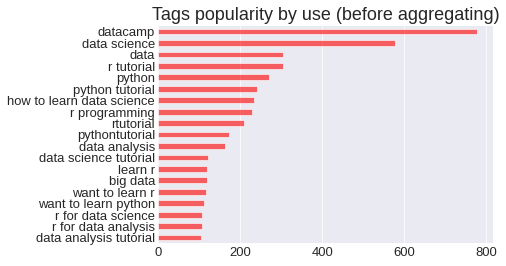

In [20]:
tags = df_yt.explode('tags')['tags']

# considering tags which were used more than 100 times
ax = tags.value_counts()[tags.value_counts() > 100].plot(kind='barh', color='r', alpha=.6)
ax.invert_yaxis()
ax.set_title('Tags popularity by use (before aggregating)')
ax.grid(b=False, axis='y')

plt.show()

As an example, we see that the **R** programming language appears in several tags.<br/> 
This kind of problem would require advanced techinques to be properly addressed.<br/> 
Instead, we will perform some quick and (surely) incomplete cleaning by using the info from the previous bar plot.

In [21]:
def uniform_most_used_tags(tags_list):
    '''returns a more uniform list of tags'''
    unif_tags_list = []
    for tag in tags_list:
        if 'r ' in tag or ' r' in tag or 'learnr' in tag or 'rtutorial' in tag:
            unif_tags_list.append('r')
        elif 'python' in tag:
            unif_tags_list.append('python')
        elif 'sql' in tag:
            unif_tags_list.append('sql')
        elif 'machinelearning' == tag:
            unif_tags_list.append('machine learning')
        else:
            unif_tags_list.append(tag)
    
    return unif_tags_list        
            
# tags_unif = df_yt['tags'].apply(uniform_most_used_tags)
df_yt['tags'] = df_yt['tags'].apply(uniform_most_used_tags)

Let's see the situation now:

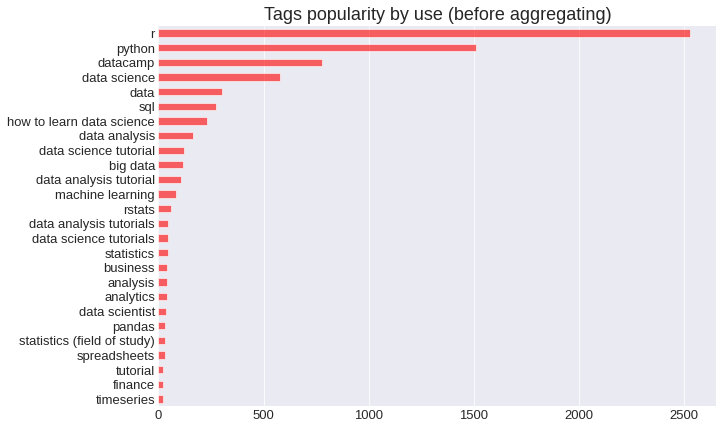

In [22]:
tags = df_yt.explode('tags')['tags']

# considering tags which were used more than 20 times
ax = tags.value_counts()[tags.value_counts() > 20].plot(kind='barh', figsize=(10,7), color='r', alpha=.6)
ax.invert_yaxis()
ax.set_title('Tags popularity by use (before aggregating)')
ax.grid(b=False, axis='y')

plt.show()

It seems better. All the tags where expressions like "data science" or "data analysis" appear are too vague and will be left as they are.

## Data analysis

After a quick look at the channel contents, we see that we have both very short (a few mins) and very long (more than an hour) videos.<br/>
Let's define **short** those videos whose length is less than 10 minutes and **long** otherwise.

In [23]:
df_yt['length'] = df_yt['duration'].apply(lambda dur: 'long' if dur >= 10 else 'short')
df_yt['NPS'] = (df_yt['likes'] - df_yt['dislikes']) / (df_yt['likes'] + df_yt['dislikes']) * 100

In the previous cell, we also defined the **Net Promoter Score** as:

    NPS = (% of likes) - (% of dislikes)

Unfortunately, the NPS doesn't seem to be a good metric here, because the vast majority of videos have only likes (i.e. NPS = 100%), and very few videos a negative score:

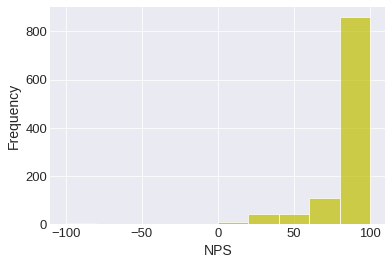

In [24]:
ax = df_yt.plot(kind='hist', y='NPS', legend=False, color='y', alpha=.7)
ax.set_xlabel('NPS')

plt.show()

On the other hand, it's probably a good idea to separate long from short videos, because they usually are very different in nature (short videos are usually very structured and to the point, long ones can be recording of live sessions or complex tutorials).<br/>
These are the histograms of video lengths:

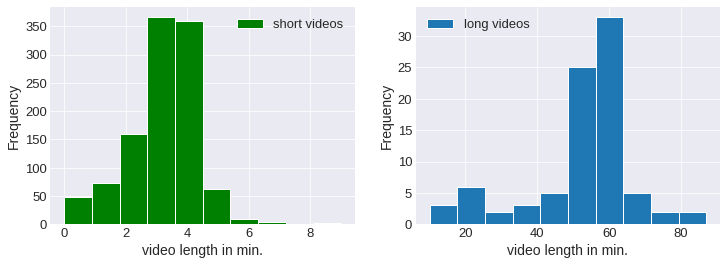

In [34]:
fig, ax = plt.subplots(1, 2)

df_yt[df_yt['length'] == 'short'].plot(kind='hist', y='duration', ax=ax[0], figsize=(12,4), color='g')
df_yt[df_yt['length'] == 'long'].plot(kind='hist', y='duration', ax=ax[1])

ax[0].set(xlabel = 'video length in min.')
ax[0].legend(labels=['short videos'])
ax[1].set(xlabel = 'video length in min.')
ax[1].legend(labels=['long videos'])

plt.show()

Beware that short videos are more than 1000, while long videos are about 80.

### - Tags popularity by views

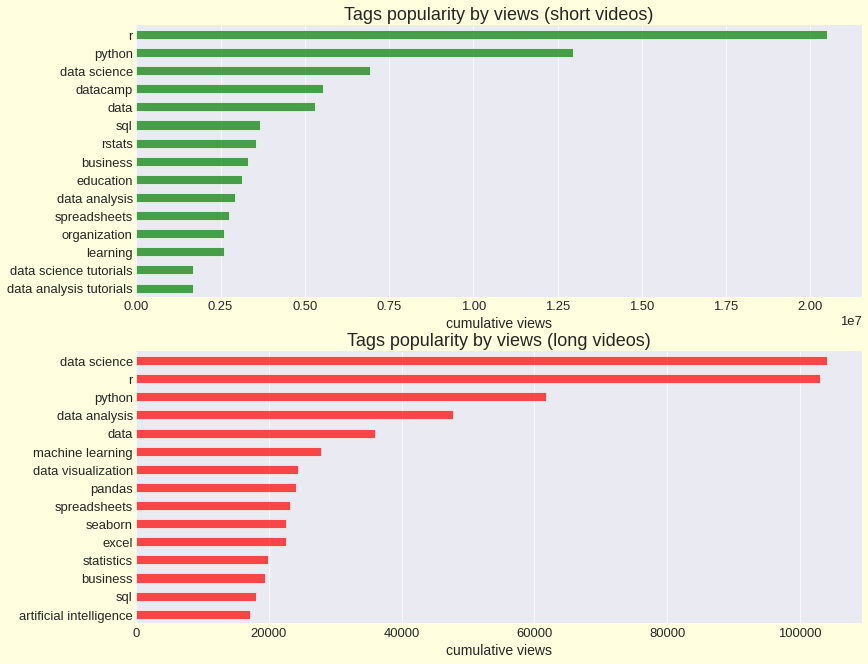

In [26]:
# preprocessing the data we need
short_videos = df_yt[df_yt['length'] == 'short']
long_videos = df_yt[df_yt['length'] == 'long']
short_videos = short_videos.explode('tags').groupby('tags')['views'].agg('sum').sort_values(ascending=False)[:15]
long_videos = long_videos.explode('tags').groupby('tags')['views'].agg('sum').sort_values(ascending=False)[:15]

# FIGURE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 11))

# UPPER FIGURE
short_videos.plot(kind='barh', ax=ax1, color='g', alpha=.7)
ax1.invert_yaxis()
ax1.set(title='Tags popularity by views (short videos)', xlabel='cumulative views')
ax1.set_ylabel('')
ax1.grid(b=False, axis='y')

# LOWER FIGURE
long_videos.plot(kind='barh', ax=ax2, color='r', alpha=.7)
ax2.set(title='Tags popularity by views (long videos)', xlabel='cumulative views')
ax2.invert_yaxis()
ax2.set_ylabel('')
ax2.grid(b=False, axis='y')

fig.set_facecolor('#FFFFE0')

### Observations:

- In both short and long videos, **R** has larger cumulative views than **Python**.
- Short videos about **SQL** are quite popular. Probably people like videos about the basics of SQL which can easily be given the shape of short tutorials.
- Long videos about **machine learning**, **data visualization**, **Pandas** and **Seaborn** are the most viewed videos after those on R and Python.
- Videos about **spreadsheets** are popular in both categories.

## Conclusions

In this project, we have tried to find the most promising Data Science topics for our company in terms of online articles to write and videos to produce.

For the online articles, we analysed data from the **Data Science Stack Exchange** explorer in order to find the tags more often used and those which gather more views.<br/>
Our suggestions and observations, in short, are:

- Articles about **Python** and **machine learning** are very popular. **R** seems less popular.
- Considered as a whole, **deep learning** and deep learning related topics are the most sought after. Articles about **neural networks** (especially **convolutional** NN), **natural language processing** or about the most used libraries (**Keras**, **TensorFlow**, **Pytorch**) for deep learning are guaranteed to attract readers.
- Clear articles about tricky aspects of **Pandas** and **Numpy** are surely to suggest. Especially Pandas can be difficult to work with in its advanced features, so well-organised tutorials would probably be welcome.
- We suggest to write clear **Matplotlib** tutorials essentially for the same reasons.

For the videos, we decided to analyse quickly the **DataCamp YT channel**, using the Youtube Data API v3 to access data and statistics.<br/>
Our suggestions are:

- Videos about **R** and **Python** are the most popular.
- We could start a series of short and clear video tutorials on the basics of **SQL**. Also, we could experiment with videos about the theory of relational databases, which are relatively rare.
- We could also consider a series on data **visualization**, using **Seaborn**.
- We should investigate more to understand which aspects/topics in **machine learning** are promising for videos.

Finally, we highlight that **deep learning** seems a solid field on which to invest: its appreciation has grown over the last years, it's now stable and won't probably fade away anytime soon.

